# Anomaly Detection using LSTM

In [2]:
# making model using one data, so result must be good unnaturaly.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Load and Show Data

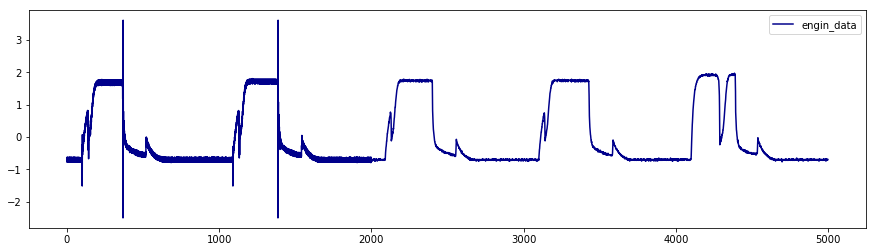

data pint : 5000


In [3]:
# load data
df = pd.read_csv("./qtdbsel102.txt",header=None, delimiter="\t")
engin_data = df.iloc[:,0].values
engin_data = engin_data.reshape(len(engin_data), -1)

# scaling
scl = StandardScaler()
engin_data = scl.fit_transform(engin_data)

# show data
plt.figure(figsize=(15,4))
plt.plot( engin_data , color = '#00008b', label="engin_data")
plt.legend()
plt.show()
print("data pint : " + str( len(engin_data)) )

# Creating Subsequence Datas

In [4]:
# y = LSTM(x)
def create_input_and_output_sequneces(time_series, look_back, output_length):
    input_seq, output_seq = [], []
    for i in range(len(time_series)-look_back-output_length):
        input_seq.append(time_series[i:i+look_back])
        output_seq.append(time_series[i+look_back:i+look_back+output_length].T[0])
    return np.array(input_seq), np.array(output_seq)

look_back = 10
output_length = 3

ok_data = engin_data[2000:3800]
data_X, data_y = create_input_and_output_sequneces(ok_data, look_back, output_length)
X_train, X_val, y_train, y_val = train_test_split(data_X, data_y, test_size=0.2)
print( X_train.shape , y_train.shape, X_val.shape, y_val.shape )

(1429, 10, 1) (1429, 3) (358, 10, 1) (358, 3)


# Model Definition

In [6]:
import torch
import torch.nn as nn

class MyLSTM(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(MyLSTM, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0) #LSTM層
        output = self.dropout(output)
        output = self.output_layer(output[:, -1, :]) #全結合層
        
        return output

In [7]:
import torch.optim as optim

vec_size, hidden_size, out_dim = 1, 16, 3
model = MyLSTM(vec_size, hidden_size, out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

# Training Loop, 後でval Loopは書く

In [9]:
from torch.autograd import Variable

best_mse = 1000000
trn_mse, val_mse = [], []
batch_size = 8
epoch_num = 200

for epoch in range(epoch_num):
    
    runnning_loss = 0.0
    train_mse = 0.0
    
    # shuffle and make batch
    shuffle_incides = np.random.permutation(np.arange(X_train.shape[0]))
    X, y = X_train[shuffle_incides], y_train[shuffle_incides]
    
    # train loop
    for i in range(int(X_train.shape[0]/batch_size)):
        
        model.train()
        optimizer.zero_grad()
        startId,endId = i*batch_size, min( (i+1)*batch_size,X_train.shape[0])
    
        inPut, outPut = X[startId:endId], y[startId:endId]
        inPut, outPut = torch.tensor(inPut), torch.tensor(outPut)
        inPut, outPut = Variable(inPut), Variable(outPut)
        
        pred = model(inPut.float())
        loss = criterion( pred, outPut.float())
        loss.backward()
        optimizer.step()
    
    # val loop 後で作る
    if (epoch % 50 == 0):
        print(epoch)

0
50
100
150


# Test Loop

In [12]:
ng_data = engin_data[4000:5000]
X_test, y_test = create_input_and_output_sequneces( ng_data, look_back, output_length)
X_test, y_test = np.array(X_test) , np.array(y_test)

In [30]:
preds_test = []
test_batch = 1

for i in range(int(X_test.shape[0]/test_batch)):
    model.eval()

    startId,endId = i*test_batch, min( (i+1)*test_batch,X_train.shape[0])
    inPut, outPut = X_test[startId:endId], y_test[startId:endId]

    inPut, outPut = torch.tensor(inPut), torch.tensor(outPut)

    pred = model(inPut.float())

    preds_test.append(pred.detach().numpy())

In [31]:
preds_test = np.array(preds_test)
print(preds_test.shape)
preds_test = np.reshape(preds_test,[preds_test.shape[0],output_length])
error_test = y_test - preds_test

(987, 1, 3)


In [29]:
print( int(X_test.shape[0]/test_batch) )

987


# Val Loop( caluculating mean and covariance for Mahalanobis DIstance )

In [35]:
preds_val = []
val_batch = 1

for i in range(int(X_val.shape[0]/val_batch)):
   
    model.eval()
    startId,endId = i*val_batch, min( (i+1)*val_batch,X_val.shape[0])
    inPut, outPut = X_val[startId:endId], y_val[startId:endId]
    inPut, outPut = torch.tensor(inPut), torch.tensor(outPut)
    pred = model(inPut.float())
    preds_val.append(pred.detach().numpy())

preds_val = np.array(preds_val)
print(preds_val.shape)
preds_val = np.reshape(preds_val,[preds_val.shape[0],output_length])
error_val = y_val - preds_val

(358, 1, 3)


In [36]:
mean = np.mean(error_val,axis=0)
cov = 0
for e in error_val:
    cov += np.dot( (e-mean).reshape(len(e),1), (e-mean).reshape(1,len(e)))
cov /= len(error_val)
print(mean)
print(cov)

[0.00192149 0.00143862 0.00533553]
[[0.00413533 0.00469684 0.00506106]
 [0.00469684 0.00692289 0.00747243]
 [0.00506106 0.00747243 0.00903123]]


In [40]:
def Mahala_distance(x,mean,cov):
    d = np.dot(x-mean, np.linalg.inv(cov))
    d = np.dot(d, (x-mean).T)
    return d

errors_test = []
for e in error_test:
    d = Mahala_distance(e,mean,cov)
    errors_test.append(d)
    
errors_test = np.array(errors_test)
print(errors_test.shape)

(987,)


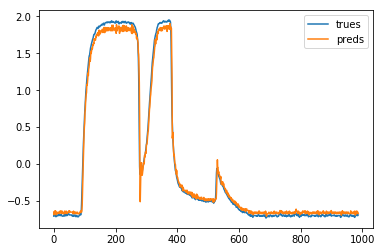

In [45]:
y_test_m = np.sum(y_test,axis=1) / 3
preds_m = np.sum(preds_test,axis=1) / 3

begin,end = 0,preds_m.shape[0]

plt.plot( y_test_m[begin:end], label='trues')
plt.plot( preds_m[begin:end], label="preds")
plt.legend()
plt.show()

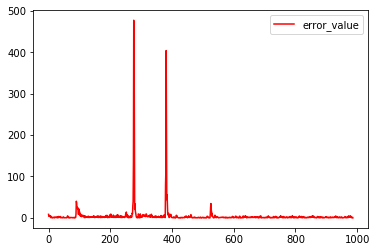

In [47]:
plt.plot( errors_test[begin:end], label='error_value',color="red")
plt.legend()
plt.show()